In [2]:
# importing packages and libraries
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn
import mxnet as mx
import numpy as np
import pandas as pd
import time
from mxnet import profiler
import re
import matplotlib.pyplot as plt
import PIL as Image

In [3]:
# setting the context for the program 
mx.test_utils.list_gpus()
if mx.context.num_gpus() > 0:
    data_ctx = mx.gpu()
    model_ctx = mx.gpu()
else:
    data_ctx = mx.cpu()
    model_ctx = mx.cpu()

In [4]:
# training transform definition
transform_train = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize((70, 70)),
    gluon.data.vision.transforms.CenterCrop((64, 64)),
    gluon.data.vision.transforms.ToTensor(), 
    # gluon.data.vision.transforms.Normalize(0.5)
])
# testing transform definition
transform_test = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize((70, 70)),
    gluon.data.vision.transforms.CenterCrop((64, 64)),
    gluon.data.vision.transforms.ToTensor(),
    # gluon.data.vision.transforms.Normalize(0.5)
])


# importing the imagenet dataset
train_data = gluon.data.vision.MNIST(root = 'mnist_data', train = True, transform = transform_train)
test_data = gluon.data.vision.MNIST(root = 'mnist_data', train = False, transform = transform_test)

# constants
BATCH_SIZE = 64
NUM_CLASSES = 10

# creating the data loader
train_loader = gluon.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = gluon.data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

# split into train and validation sets
X_train = train_data._data
y_train = train_data._label
X_test = test_data._data
y_test = test_data._label

# reshaping
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

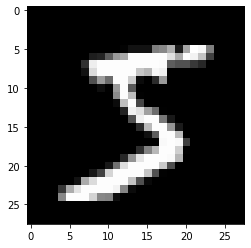

In [5]:
plt.imshow((X_train[0][0]*(255.0)).asnumpy(), cmap = 'gray')

In [7]:
class CNN(nn.Block):
    def __init__(self, **kwargs):
        super(CNN, self).__init__(**kwargs)
        self.feature_extraction = nn.Sequential()
        self.feature_extraction.add([
            nn.Conv2D(channels = 96, kernel_size = 11, strides = 4, activation = 'relu'),
            nn.MaxPool2D(pool_size = 3, strides = 2), 
            nn.Conv2D(channels = 256, kernel_size = 5, padding = 2, activation = 'relu'),
            nn.MaxPool2D(pool_size = 3, strides = 1, padding = 1), 
            nn.Conv2D(channels = 384, kernel_size = 3, padding = 1, activation = 'relu'), 
            nn.Conv2D(channels = 256, kernel_size = 3, padding = 1, activation = 'relu'),
            nn.MaxPool2D(pool_size = 3, strides = 2)
        ])
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential()
        self.classifier.add([
            nn.Dense(4096, activation = 'relu'),
            nn.Dense(4096, activation = 'relu'),
            nn.Dense(10, activation = 'softmax')
        ])

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model = CNN()
model

CNN(
  (feature_extraction): Sequential(
    (0): [Conv2D(None -> 96, kernel_size=(11, 11), stride=(4, 4), Activation(relu)), MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW), Conv2D(None -> 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu)), MaxPool2D(size=(3, 3), stride=(1, 1), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW), Conv2D(None -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu)), Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu)), MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)]
  )
  (flatten): Flatten
  (classifier): Sequential(
    (0): [Dense(None -> 4096, Activation(relu)), Dense(None -> 4096, Activation(relu)), Dense(None -> 10, Activation(softmax))]
  )
)

In [ ]:
model.initialize()

preds = model(X_train[:5])

preds

In [ ]:
for layer_name, weights in model.collect_params().items():
    print("{} - {}".format(layer_name,weights.shape))


In [ ]:
from mxnet import autograd

def TrainModelInBatches(trainer, X, Y, epochs, batch_size=32):
    for i in range(1, epochs+1):
        batches = nd.arange((X.shape[0]//batch_size)+1) ### Batch Indices

        losses = [] ## Record loss of each batch
        for batch in batches:
            batch = batch.asscalar()
            if batch != batches[-1]:
                start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
            else:
                start, end = int(batch*batch_size), None

            X_batch, Y_batch = X[start:end], Y[start:end] ## Single batch of data

            with autograd.record():
                preds = model(X_batch) ## Forward pass to make predictions
                loss_val = loss_func(preds.squeeze(), Y_batch) ## Calculate Loss
            loss_val.backward() ## Calculate Gradients

            loss_val = loss_val.mean().asscalar()
            losses.append(loss_val)

            trainer.step(len(X_batch)) ## Update weights

        print("CrossEntropyLoss : {:.3f}".format(np.array(losses).mean()))

In [ ]:
from mxnet import gluon
from mxnet.gluon import loss
from mxnet import autograd

batch_size=256
epochs=25
learning_rate = 0.001

model = CNN()
model.initialize()
loss_func = loss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(model.collect_params(), "adam", {"learning_rate": learning_rate})

TrainModelInBatches(trainer, X_train, y_train, epochs, batch_size=batch_size)